# Spaceship Titanic

## Load libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

from termcolor import colored
import pylab
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# sklearn tools and models
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Getting data

In [2]:
# Full test and train dataset
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

# Copy
train_df = train
test_df = test

## Functions

##### Quick look function

In [3]:
# Function to print main info about the dataset
def quick_look(df):
    print(colored('SIZE' , 'blue', attrs=['bold', 'dark']))
    print(df.size)
    print(colored('\nSHAPE' , 'blue', attrs=['bold', 'dark']))
    print(df.shape)
    print(colored('\nINFO' , 'blue', attrs=['bold', 'dark']))
    print(df.info())
    print(colored('\nNULL VALUES' , 'blue', attrs=['bold', 'dark']))
    print(df.isnull().sum())
    print(colored('\nHEAD' , 'blue', attrs=['bold', 'dark']))
    print(df.head())
    print(colored('\nDESCRIBE - Numerical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe())
    print(colored('\nDESCRIBE - Categorical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe(include='object'))
    print(colored('\nUNIQUE ENTRIES IN EACH CATEGORICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with categorical data
    object_cols = [col for col in df.columns if df[col].dtype == "object"]
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    d = dict(zip(object_cols, object_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(d.items(), key=lambda x: x[1]))

## Data Analisys and Statistics

##### Train data

In [4]:
quick_look(train_df)

SIZE
121702

SHAPE
(8693, 14)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

NULL VALUES
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destinat

##### Test data

In [5]:
quick_look(test_df)

SIZE
55601

SHAPE
(4277, 13)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB
None

NULL VALUES
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
R

### Data Processing

#### Summary

- PassengerId: parse into Passenger_Group, Passenger_Num, and Group_Size
- HomePlanet: impute most frequent and convert to categorical
- CryoSleep: impute most frequent; convert to boolean
- Cabin: Fill missing values with 'Z/99999/Z' and parse into new Cabin_Deck, Cabin_Num, and Cabin_Side features
- Destination: impute most frequent and convert to categorical
- Age: Impute median value
- VIP: Impute most frequent and convert to boolean
- RoomService: Impute median value
- FoodCourt: Impute median value
- ShoppingMall: Impute median value
- Spa: Impute median value
- VRDeck: Impute median value
- Name: impute 'NoFirstName NoLastName'
- Transported: converted to Boolean; train data only

#### Joining Train and Test

In [6]:
# combine into a single list
full_data = [train_df, test_df]

#### Missing values

In [7]:
# convert Transported to boolean; only in train_df 
train_df['Transported'] = train_df['Transported'].astype(bool)

# format bulk of data sets 
for df in full_data:

    # IMPUTE MISSING VALUES 
    df['Name'].fillna('NoFirstName NoSurname', inplace=True)
    df['HomePlanet'].fillna(df['HomePlanet'].value_counts().index[0], inplace=True)
    df['CryoSleep'].fillna(df['CryoSleep'].value_counts().index[0], inplace=True)
    df['Cabin'].fillna('Z/99999/Z', inplace=True)
    df['Destination'].fillna(df['Destination'].value_counts().index[0], inplace=True)
    df['VIP'].fillna(df['VIP'].value_counts().index[0], inplace=True)
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['RoomService'].fillna(df['RoomService'].median(), inplace=True)
    df['FoodCourt'].fillna(df['FoodCourt'].median(), inplace=True)
    df['ShoppingMall'].fillna(df['ShoppingMall'].median(), inplace=True)
    df['Spa'].fillna(df['Spa'].median(), inplace=True)
    df['VRDeck'].fillna(df['VRDeck'].median(), inplace=True)
    
    # Split columns to create features 
    df['Passenger_Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(str)
    df['Passenger_Num'] = df['PassengerId'].apply(lambda x: x.split('_')[1]).astype(str)
    df['Cabin_Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0]).astype(str)
    df['Cabin_Num'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(str)
    df['Cabin_Side'] = df['Cabin'].apply(lambda x: x.split('/')[2]).astype(str) 

    # FORMAT DATA TYPES 
    df['HomePlanet'] = df['HomePlanet'].astype('category')
    df['CryoSleep'] = df['CryoSleep'].astype('bool')
    df['Cabin_Deck'] = df['Cabin_Deck'].astype('category')
    df['Cabin_Side'] = df['Cabin_Side'].astype('category')
    df['Destination'] = df['Destination'].astype('category')

In [8]:
# use completed features to generate new features - Crete Group_Size based on Passenger_Group
for df in full_data:
    df['Group_Size'] = df['Passenger_Group'].map(lambda x: pd.concat([train_df['Passenger_Group'], test_df['Passenger_Group']]).value_counts()[x])

In [9]:
quick_look(train_df)

SIZE
173860

SHAPE
(8693, 20)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      8693 non-null   object  
 1   HomePlanet       8693 non-null   category
 2   CryoSleep        8693 non-null   bool    
 3   Cabin            8693 non-null   object  
 4   Destination      8693 non-null   category
 5   Age              8693 non-null   float64 
 6   VIP              8693 non-null   bool    
 7   RoomService      8693 non-null   float64 
 8   FoodCourt        8693 non-null   float64 
 9   ShoppingMall     8693 non-null   float64 
 10  Spa              8693 non-null   float64 
 11  VRDeck           8693 non-null   float64 
 12  Name             8693 non-null   object  
 13  Transported      8693 non-null   bool    
 14  Passenger_Group  8693 non-null   object  
 15  Passenger_Num    8693 non-null   object  
 16  Cabin_

In [10]:
quick_look(test_df)

SIZE
81263

SHAPE
(4277, 19)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      4277 non-null   object  
 1   HomePlanet       4277 non-null   category
 2   CryoSleep        4277 non-null   bool    
 3   Cabin            4277 non-null   object  
 4   Destination      4277 non-null   category
 5   Age              4277 non-null   float64 
 6   VIP              4277 non-null   bool    
 7   RoomService      4277 non-null   float64 
 8   FoodCourt        4277 non-null   float64 
 9   ShoppingMall     4277 non-null   float64 
 10  Spa              4277 non-null   float64 
 11  VRDeck           4277 non-null   float64 
 12  Name             4277 non-null   object  
 13  Passenger_Group  4277 non-null   object  
 14  Passenger_Num    4277 non-null   object  
 15  Cabin_Deck       4277 non-null   category
 16  Cabin_N

### Categorical Analisys

#### Passanger ID
Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
Passanger ID was used to create additional features:
- Passenger_Group for each group
- Passenger_Num for each group member
- Group_Size to count the number of members in each group

##### Group Size

<AxesSubplot:title={'center':'Group Size - Train'}>

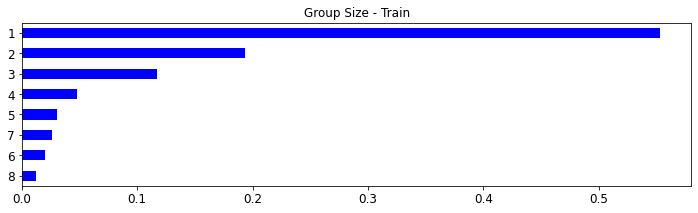

In [11]:
train_df['Group_Size'].value_counts(normalize=True).sort_values(ascending=True).plot(kind='barh', 
        figsize=(12,3),
        title='Group Size - Train',
        color='blue')

<AxesSubplot:title={'center':'Group Size - Test'}>

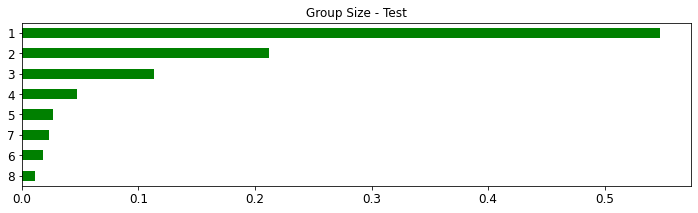

In [12]:
test_df['Group_Size'].value_counts(normalize=True).sort_values(ascending=True).plot(kind='barh', 
        figsize=(12,3),
        title='Group Size - Test',
        color='green')

<AxesSubplot:title={'center':'Group Size - Transported'}, ylabel='Group_Size'>

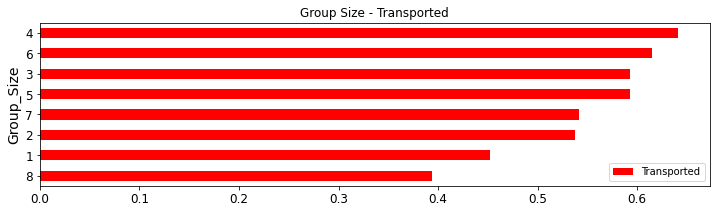

In [13]:
train_df[['Group_Size', 'Transported']].groupby('Group_Size').agg('mean').sort_values('Transported').plot(kind='barh',
          figsize=(12,3),
          color = 'red',
          title='Group Size - Transported')

#### Analysis of Group Size
- Both train and test datasets show that more than 50% of the transported people are group of 1 person
- Group between 2 and 7 peoples have a slightly higher change of being transported then group with 1 or 8 people 

#### Home Planet
The planet the passenger departed from, typically their planet of permanent residence.

<AxesSubplot:title={'center':'Home Planet - Train'}>

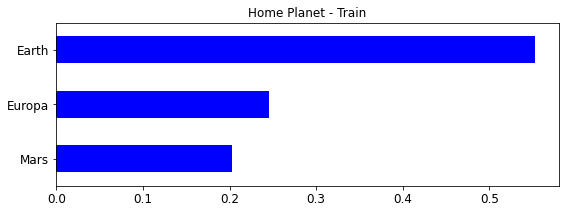

In [14]:
train_df['HomePlanet'].value_counts(normalize=True).sort_values(ascending=True).plot(kind='barh', 
        figsize=(9,3),
        title='Home Planet - Train',
        color='blue')

<AxesSubplot:title={'center':'Home Planet - Test'}>

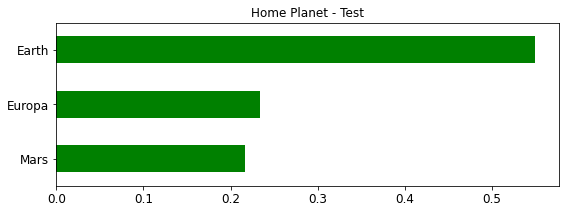

In [15]:
test_df['HomePlanet'].value_counts(normalize=True).sort_values(ascending=True).plot(kind='barh', 
        figsize=(9,3),
        title='Home Planet - Test',
        color='green')

<AxesSubplot:title={'center':'Home Planet - Transported'}, ylabel='HomePlanet'>

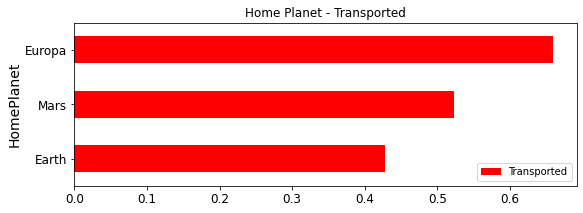

In [16]:
train_df[['HomePlanet', 'Transported']].groupby('HomePlanet').agg('mean').sort_values('Transported').plot(kind='barh',
          figsize=(9,3),
          color = 'red',
          title='Home Planet - Transported')

#### Analysis of Home Planet
- Train and Test dataset have very similar distribuition of passangers among Earth (~55%), Europa (~25%), and Mars (~20%)
- Most passagengers come from Earth
- Passangers from Europa are more likely to be transported (~65%), compared with passangers from Earth (~52%) and Mars (~42%)

### CryoSleep

### Quantitative analisys

### Separate target from predictors

In [47]:
# Remove rows with missing target
X_full.dropna(axis=0, subset=['Transported'], inplace=True) # drop the target column from X_full

# Separate target from predictors
y = X_full.Transported # make Y the target
X_full.drop('Transported', axis=1, inplace=True)

In [23]:
# Quick view on X_full
#quick_look(X_full)

In [24]:
# Quick view on X_valid
#quick_look(X_valid)

In [48]:
# Break off validation set from data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2, random_state=0)

#### Numerical and Categorical Columns

In [49]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [60]:
my_cols
#quick_look(X_test)

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck']

#### Preprocessing Numerical and Categorical Data

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 0.2861837679871813


In [58]:
# Preprocessing of test data, fit model
preds_test = clf.predict(X_test)

#### Save test predictions to file

In [68]:
# Save test predictions to file
output = pd.DataFrame({'PassengerId': X_test_full.PassengerId,
                       'Transported': preds_test})
output.to_csv('submission.csv', index=False)

# IGNORE BELOW

#### Numerical Columns - Drop columns with categorical data

In [26]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

In [27]:
quick_look(drop_X_train)

SIZE
41724

SHAPE
(6954, 6)

INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 4278 to 2732
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           6808 non-null   float64
 1   RoomService   6803 non-null   float64
 2   FoodCourt     6806 non-null   float64
 3   ShoppingMall  6782 non-null   float64
 4   Spa           6802 non-null   float64
 5   VRDeck        6808 non-null   float64
dtypes: float64(6)
memory usage: 380.3 KB
None

NULL VALUES
Age             146
RoomService     151
FoodCourt       148
ShoppingMall    172
Spa             152
VRDeck          146
dtype: int64

HEAD
       Age  RoomService  FoodCourt  ShoppingMall      Spa  VRDeck
4278  54.0          0.0      559.0           0.0  15238.0  2799.0
5971  20.0          0.0       20.0           1.0    696.0     0.0
464   43.0       1821.0        0.0          47.0     29.0     0.0
4475  24.0        185.0        0.0         476.0  

#### Missing values in numerical variables - Imputation 

In [28]:
# Imputation
my_imputer = SimpleImputer(strategy="median")

imputed_x_train = pd.DataFrame(imputer.fit_transform(drop_X_train))
imputed_x_valid = pd.DataFrame(imputer.transform(drop_X_valid))

# Fill in the lines below: imputation removed column names; put them back
imputed_x_train.columns = drop_X_train.columns
imputed_x_valid.columns = drop_X_valid.columns

NameError: name 'imputer' is not defined

In [29]:
quick_look(imputed_x_train)

NameError: name 'imputed_x_train' is not defined

#### Categorical columns - Ordinal Encoder

In [34]:
# Categorical columns in the training data
object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_valid[col]).issubset(set(X_train[col]))]

# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))
        
print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

Categorical columns that will be ordinal encoded: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

Categorical columns that will be dropped from the dataset: ['Cabin', 'PassengerId', 'Name']


In [36]:
from sklearn.preprocessing import OrdinalEncoder

# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(bad_label_cols, axis=1)
label_X_valid = X_valid.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
ordinal_encoder = OrdinalEncoder() 
label_X_train[good_label_cols] = ordinal_encoder.fit_transform(X_train[good_label_cols])
label_X_valid[good_label_cols] = ordinal_encoder.transform(X_valid[good_label_cols])

In [35]:
quick_look(good_label_cols)

SIZE


AttributeError: 'list' object has no attribute 'size'

#### Vizualizing the data

In [106]:
def vizualize_hist(df):
    for column in df:
        if df[column].dtype == "object":
            pass
        else:
            df[column] = df[column].replace({0:np.nan})
            pylab.figure()
            pylab.hist(df[column][~np.isnan(df[column])], bins=50, main=colnames(df[[column]]))
            pylab.show()


In [163]:
#vizualize_hist(test_df)

### Tests

In [222]:
# Function for comparing different aproches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [230]:
print("MAE - Aproach 1 (Drop categorical variables + Imputation):")
print(score_dataset(imputed_x_train, imputed_x_valid, y_train, y_valid))

MAE - Aproach 1 (Drop categorical variables + Imputation):
0.3155578390619056
